https://youtu.be/nCMDZEScF-4

**Nuclei segmentation in whole slide H&E images**

using pre-trained StarDist model.

This is pretty much all taken from Dr. Sreenivas Bhattiprolu's github:
https://github.com/bnsreenu/python_for_microscopists/blob/master/281_Segmenting_WSI_using_StarDist.ipynb

In [1]:
# !pip install stardist
# !pip install tensorflow

In [2]:
# To read Tiff files on Colab we need to install imagecodecs library
# !pip install imagecodecs  

In [30]:
import numpy as np
import matplotlib.pyplot as plt

from tifffile import imread, imsave
from csbdeep.utils import Path, normalize
from csbdeep.utils.tf import keras_import
keras = keras_import()

from stardist import export_imagej_rois, random_label_cmap
from stardist.models import StarDist2D
import os

import  tensorflow as tf
from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
import copy
import json
from stardist.models import Config2D, StarDist2D, StarDistData2D

np.random.seed(0)
cmap = random_label_cmap()

In [31]:
pth0=r'\\10.99.68.178\andreex\data\Stardist'
pthtraining= os.path.join(pth0,'Training')
pthtesting= os.path.join(pth0,'Testing')
pthmodels= os.path.join(pth0,'models')
pthfiles= os.path.join(pth0,'files')
pthHE= os.path.join(pthtraining,'H&E_tiles')
pthmasks= os.path.join(pthtraining,'Mask_tiles')

In [5]:
pth = r'\\169.254.138.20\Andre\data\Ashleigh fallopian tube\fallopian tubes\AJER376'  # path of ndpi files
pth_mat = r'\\169.254.138.20\Andre\data\Ashleigh fallopian tube\fallopian tubes\AJER376\1x_python\cropped\matfiles'  # path .mat files with 
# Get a list of MAT files and their base names (without extensions)
mat_files = [os.path.splitext(file)[0] for file in os.listdir(pth_mat) if file.endswith('.mat')]

# Get a list of NDPI images and their base names (without extensions)
ndpi_files = [os.path.splitext(file)[0] for file in os.listdir(pth) if file.endswith('.ndpi')]

# Find the matching files based on their base names
matching_files = set(mat_files).intersection(ndpi_files)

WSIs = [filename + '.ndpi' for filename in matching_files]

In [4]:
def show_image(img, crop_x, crop_y, tile_size, **kwargs):
    """Plot large image at different resolutions."""
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))

    # Plot the original image on the left
    ax[0].imshow(img, **kwargs)

    # Crop the image
    cropped_img = img[crop_y:crop_y+tile_size, crop_x:crop_x+tile_size]

    # Plot the cropped image on the right
    ax[1].imshow(cropped_img, **kwargs)

    ax[0].axis('off')
    ax[1].axis('off')

    plt.tight_layout()
    plt.show()

In [32]:
if tf.config.list_physical_devices('GPU'):
    print("GPU is available")
else:
    print("GPU is not available")
    
print(tf.__version__)

#Define the config by setting some parameter values
# 32 is a good default choice (see 1_data.ipynb)
n_rays = 32  #Number of radial directions for the star-convex polygon.

# Use OpenCL-based computations for data generator during training (requires 'gputools')
use_gpu = True and gputools_available()

# Predict on subsampled grid for increased efficiency and larger field of view
grid = (2,2)

n_channel = 3


conf = Config2D (
    n_rays       = n_rays,
    grid         = grid,
    use_gpu      = use_gpu,
    n_channel_in = n_channel,
)
# print(conf)
vars(conf)

def load_model(model_path: str) -> StarDist2D:
    # Load StarDist model weights, configurations, and thresholds
    with open(model_path + '\\config.json', 'r') as f:
        config = json.load(f)
    with open(model_path + '\\thresholds.json', 'r') as f:
        thresh = json.load(f)
    model = StarDist2D(config=Config2D(**config), basedir=model_path, name='offshoot_model')
    model.thresholds = thresh
    print('Overriding defaults:', model.thresholds, '\n')
    model.load_weights(model_path + '\\weights_best.h5')
    return model

GPU is available
2.10.1
If you want to compute separable approximations, please install it with
pip install scikit-tensor-py3


In [6]:
imgs = []

# you might need to run "pip install imagecodecs" if you get jpeg compression error

for file in WSIs:
    print(os.path.join(pth,file))
    im = imread(os.path.join(pth,file))
    imgs.append(im)

\\169.254.138.20\Andre\data\Ashleigh fallopian tube\fallopian tubes\AJER376\fallopian_tubes_AJER376_157.ndpi
\\169.254.138.20\Andre\data\Ashleigh fallopian tube\fallopian tubes\AJER376\fallopian_tubes_AJER376_565.ndpi
\\169.254.138.20\Andre\data\Ashleigh fallopian tube\fallopian tubes\AJER376\fallopian_tubes_AJER376_377.ndpi
\\169.254.138.20\Andre\data\Ashleigh fallopian tube\fallopian tubes\AJER376\fallopian_tubes_AJER376_479.ndpi
\\169.254.138.20\Andre\data\Ashleigh fallopian tube\fallopian tubes\AJER376\fallopian_tubes_AJER376_271.ndpi


In [7]:
WSIs

['fallopian_tubes_AJER376_157.ndpi',
 'fallopian_tubes_AJER376_565.ndpi',
 'fallopian_tubes_AJER376_377.ndpi',
 'fallopian_tubes_AJER376_479.ndpi',
 'fallopian_tubes_AJER376_271.ndpi']

In [10]:
for img in imgs:
    print(img.shape)

(47872, 61440, 3)
(40832, 44160, 3)
(47872, 59520, 3)
(46464, 59520, 3)
(47872, 65280, 3)


In [11]:
from scipy.io import loadmat
import h5py

def get_crop_info(mat_file_name, ratio) -> tuple:

    crop_width = 512
    crop_height = 512
    try:
        data = loadmat(mat_file_name+'.mat')

        crop_x = int(data['crop_x']*ratio)
        crop_y = int(data['crop_y']*ratio)
    except:
        print(mat_file_name+'.mat')
        data = h5py.File(mat_file_name+'.mat', 'r')

        crop_x = int(data['crop_x'][()]*ratio)
        crop_y = int(data['crop_y'][()]*ratio)

    return (crop_x, crop_y, crop_width)



In [23]:

ind = 3

mat_file_path = os.path.join(pth_mat, mat_files[ind])
res20x=0.4416
res10x=8
ratio = res10x/res20x
# ratio = 16

crop_x, crop_y, tile_size = crop_info = get_crop_info(mat_file_path, ratio)

\\169.254.138.20\Andre\data\Ashleigh fallopian tube\fallopian tubes\AJER376\1x_python\cropped\matfiles\fallopian_tubes_AJER376_479.mat


3274118213.py (17): Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
3274118213.py (18): Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)


In [24]:
ind

3

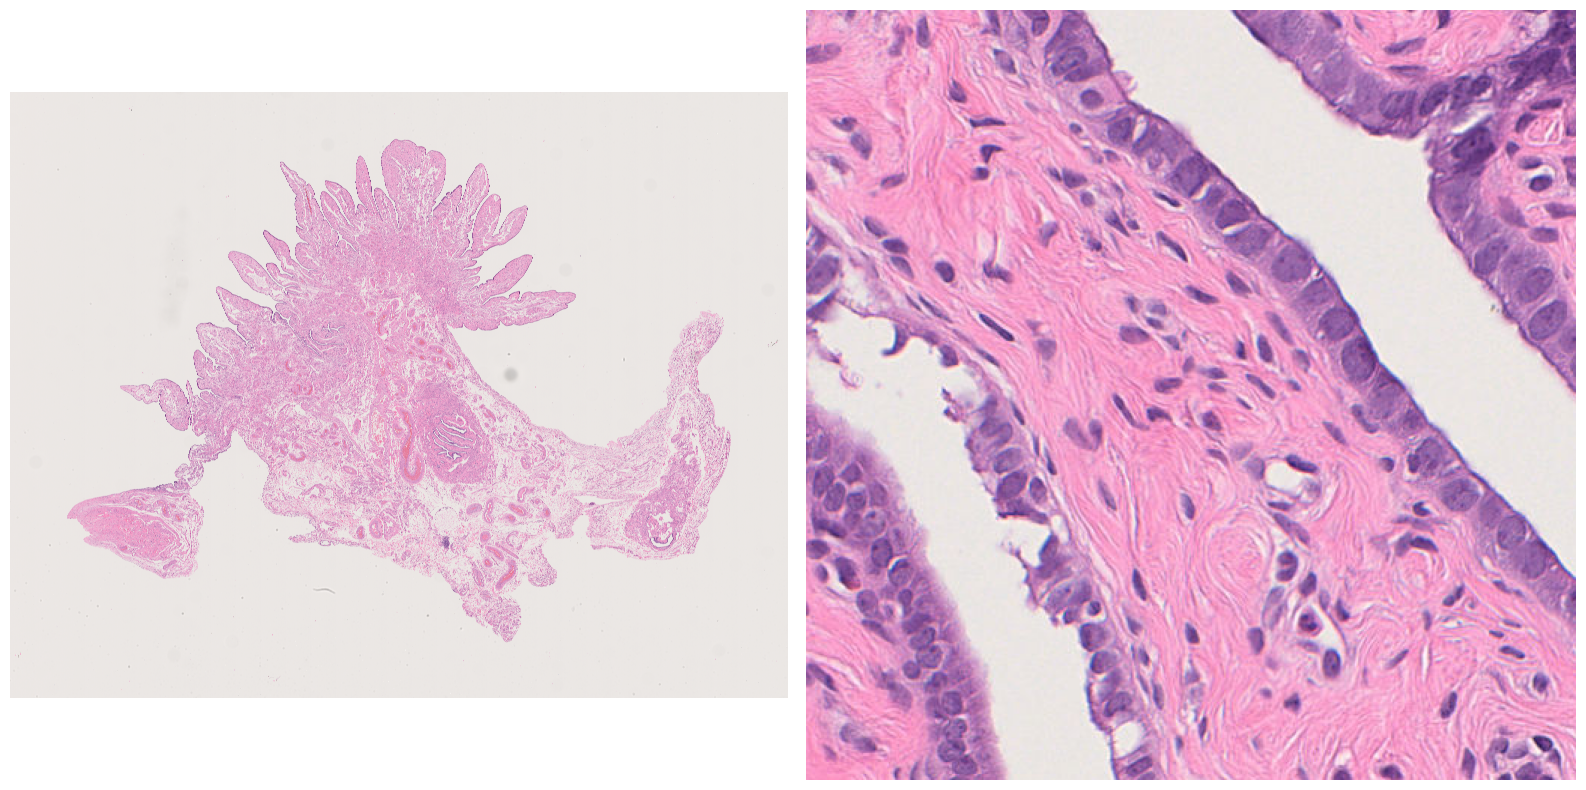

In [25]:
show_image(imgs[ind], crop_x, crop_y, tile_size)

In [33]:
from csbdeep.data import Normalizer, normalize_mi_ma

class MyNormalizer2(Normalizer):
    def __init__(self, mi, ma):
            self.mi, self.ma = mi, ma
    def before(self, x, axes):
        return normalize_mi_ma(x, self.mi, self.ma, dtype=np.float32)
    def after(*args, **kwargs):
        assert False
    @property
    def do_after(self):
        return False

mi, ma = np.percentile(imgs[3], [2,98])                      # compute percentiles from low-resolution image
# mi, ma = np.percentile(img[13000:16000,13000:16000], [1,99.8])  # compute percentiles from smaller crop
normalizer2 = MyNormalizer2(mi, ma)

In [ ]:
# model = StarDist2D(None, name='monkey_tile_trained', basedir=r'\\10.99.68.178\andreex\data\monkey fetus\gestational 40\stardist_models')

In [34]:
# creates a pretrained model
modelpretrained = StarDist2D.from_pretrained('2D_versatile_he')

outname='monkey_fallopian_tube_AF__11_03_2023_1e-4'
pth_model= os.path.join(pthmodels,outname)
model = load_model(pth_model)

Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


base_model.py (149): output path for model already exists, files may be overwritten: \\10.99.68.178\andreex\data\Stardist\models\monkey_fallopian_tube_AF__11_03_2023_1e-4\offshoot_model


Using default values: prob_thresh=0.5, nms_thresh=0.4.
Overriding defaults: Thresholds(prob=0.63499129199699, nms=0.3) 


In [35]:
labels, polys = model.predict_instances_big(imgs[3], axes='YXC', block_size=4096, min_overlap=128, context=128,
                                            normalizer=normalizer2, n_tiles=(4,4,1))


effective: block_size=(4096, 4096, 3), min_overlap=(128, 128, 0), context=(128, 128, 0)


 38%|███▊      | 78/208 [13:50<23:04, 10.65s/it]

KeyboardInterrupt



In [ ]:
labelspretrained, polyspretrained = modelpretrained.predict_instances_big(imgs[3], axes='YXC', block_size=4096, min_overlap=128, context=128, normalizer=normalizer2, n_tiles=(4,4,1))

In [36]:
img = imgs[3]
cropped_img = img[crop_y:crop_y+tile_size, crop_x:crop_x+tile_size]
cropped_labels = labels[crop_y:crop_y+tile_size, crop_x:crop_x+tile_size]
cropped_labels_pretrained = labelspretrained[crop_y:crop_y+tile_size, crop_x:crop_x+tile_size]

NameError: name 'labels' is not defined

NameError: name 'cropped_labels' is not defined

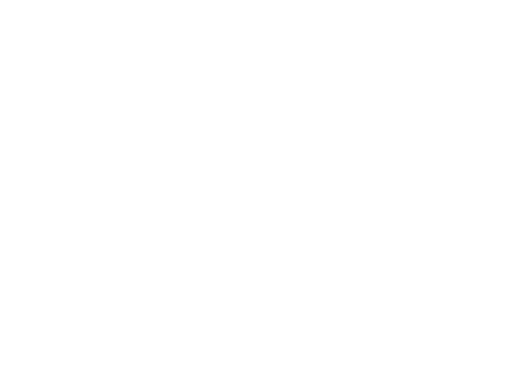

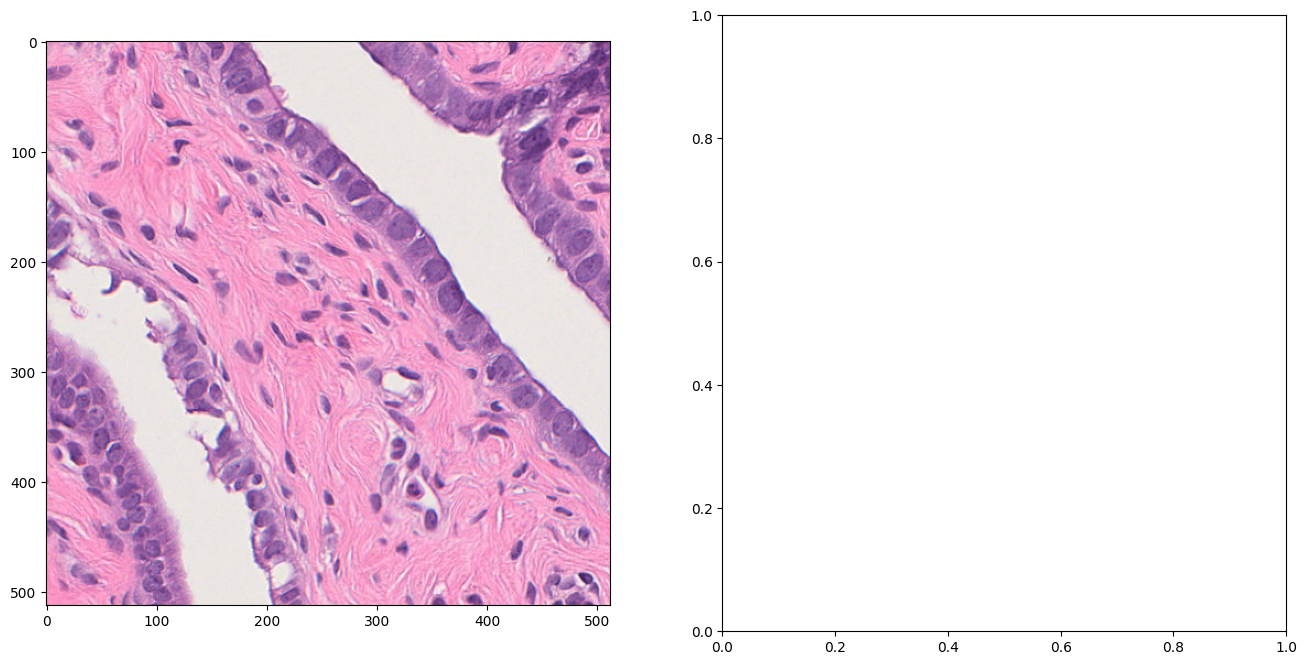

In [37]:
plt.axis('off');
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].imshow(cropped_img)
ax[0].imshow(cropped_labels, cmap=cmap, alpha=0.7)
ax[0].set_title('donald trained')

ax[1].imshow(cropped_img)
ax[1].imshow(cropped_labels_pretrained, cmap=cmap, alpha=0.7)
ax[1].set_title('pretrained')
ax[0].axis('off')
ax[1].axis('off')
plt.tight_layout()
plt.show()

In [38]:
imgs_cropped = []
labels_cropped=[]
polys_cropped=[]

for img in imgs:
    crop_img = img[crop_y:crop_y + tile_size, crop_x:crop_x + tile_size]
    imgs_cropped.append(crop_img)
    
    labels_crop, polys_crop = model.predict_instances_big(crop_img, axes='YXC', block_size=512, min_overlap=128, context=128, normalizer=normalizer2, n_tiles=(4,4,1))
    labels_cropped.append(labels_crop)
    polys_cropped.append(polys_crop)

effective: block_size=(512, 512, 3), min_overlap=(128, 128, 0), context=(128, 128, 0)


100%|██████████| 1/1 [00:01<00:00,  2.00s/it]

effective: block_size=(512, 512, 3), min_overlap=(128, 128, 0), context=(128, 128, 0)



100%|██████████| 1/1 [00:01<00:00,  1.06s/it]

effective: block_size=(512, 512, 3), min_overlap=(128, 128, 0), context=(128, 128, 0)



100%|██████████| 1/1 [00:01<00:00,  1.01s/it]

effective: block_size=(512, 512, 3), min_overlap=(128, 128, 0), context=(128, 128, 0)



100%|██████████| 1/1 [00:00<00:00,  1.02it/s]

effective: block_size=(512, 512, 3), min_overlap=(128, 128, 0), context=(128, 128, 0)



100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


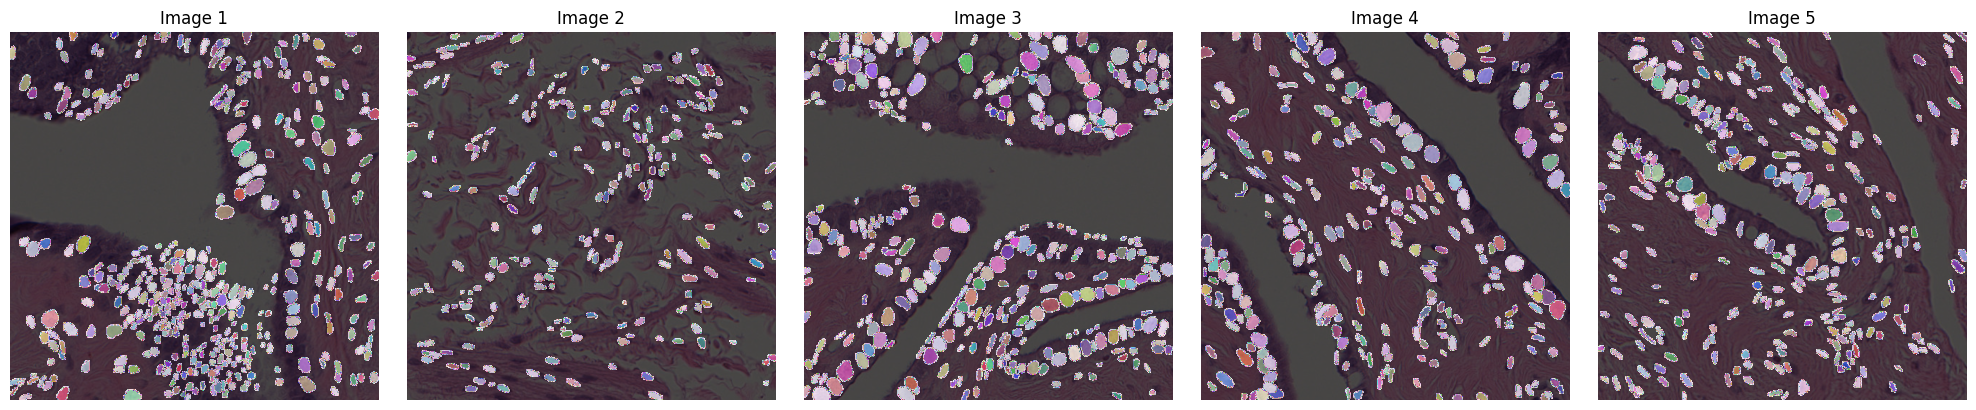

In [39]:
num_images = len(imgs_cropped)
# print(num_images)
# Create a subplot grid with 'num_images' rows and 2 columns# Create a subplot grid with 'num_images' rows and 1 column
fig, ax = plt.subplots(1,num_images, figsize=(4*num_images,4))

for i in range(num_images):
    # Plot the cropped image
    ax[i].imshow(imgs_cropped[i])  # Change the cmap if your images are not grayscale
    ax[i].imshow(labels_cropped[i], cmap=cmap, alpha=0.7)
    ax[i].set_title(f'Image {i + 1}')
    ax[i].axis('off')

plt.tight_layout()
plt.show()

NOW CHECK GROUND TRUTH ANNOTATIONS:


Now that we saw how it does on first tile, lets do it on all tiles and save

In [40]:
import json
import geojson
from pathlib import Path

# correct format for geojson export file (centroids, contours, etc.)
type_info = Path(r"\\10.99.68.178\andreex\data\monkey fetus\gestational 40\1024tiles\qupath_json_format_file\monkey_fetus_40_0105_ecm.geojson")
info = json.load(open(type_info,'r'))#

In [41]:
name = WSIs[0][:-5]
print(name)

fallopian_tubes_AJER376_157


Finished fallopian_tubes_AJER376_157.geojson
Finished fallopian_tubes_AJER376_565.geojson
Finished fallopian_tubes_AJER376_377.geojson
Finished fallopian_tubes_AJER376_479.geojson
Finished fallopian_tubes_AJER376_271.geojson


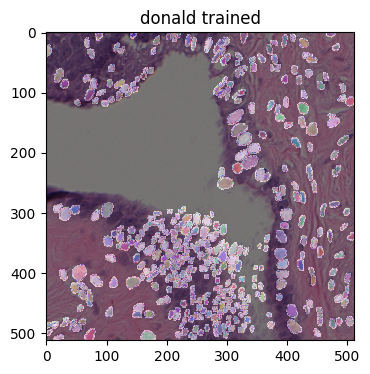

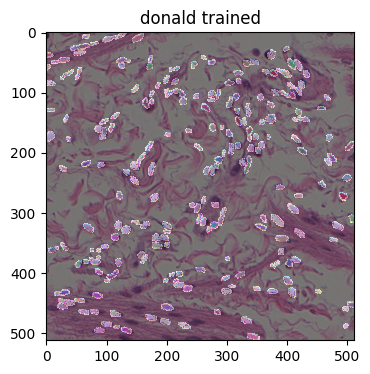

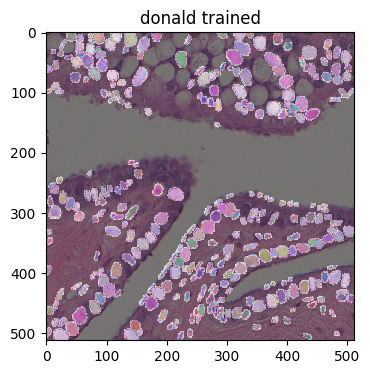

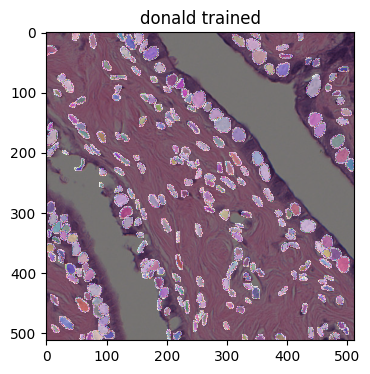

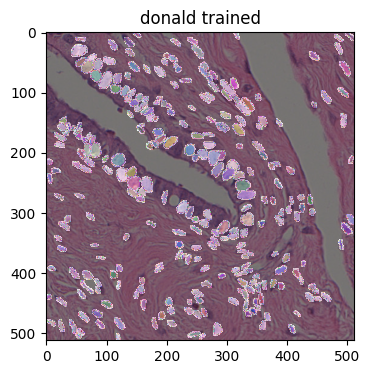

In [42]:
from PIL import Image
cc=0
# imgs_cropped = []
# labels_cropped=[]
# polys_cropped=[]
out_pth = Path(r'\\169.254.138.20\Andre\data\Ashleigh fallopian tube\fallopian tubes\AJER376\stardist_training_tiles512\stardist_segmented_jsons')
outpthtiles = os.path.join(out_pth,'tiles_512')
file_format='.tif'

while cc < len(imgs_cropped):
    name = WSIs[cc][:-5]
    result = model.predict_instances(imgs_cropped[cc], normalizer=normalizer2)

    # save centroids and contours in geojson format to import into qupath
    coords = result[1]['coord']
    # print(len(coords[0][0]))
    contours = []
    for xy in coords:
        contour = []
        for i in range(len(xy[0])):
            p = [xy[0][i], xy[1][i]]  # [x, y]
            contour.append(p)
        contours.append(contour)

    data_stardist = []
    for i in range(len(result[1]['points'])):
        nucleus = result[1]['points'][i]
        contour = contours[i]
        both = [nucleus, contour]
        data_stardist.append(both)

    GEOdata = []

    for centroid, contour in data_stardist:
        # xy coordinates are swapped, so I reverse them here with xy[::-1]
        contour = [[int(coord) for coord in xy[::-1]] for xy in contour]  # Convert coordinates to integers
        contour.append(contour[0]) # stardist doesn't close the circle, needed for qupath

        # Create a new dictionary for each contour
        dict_data = {
            "type": "Feature",
            "id": "PathCellObject",
            "geometry": {
                "type": "Polygon",
                "coordinates": [contour]
            },
            "properties": {
                'objectType': 'annotation',
                'classification': {'name': 'Nuclei', 'color': [97, 214, 59]}
            }
        }

        GEOdata.append(dict_data)

    new_fn = name + '.geojson'

    with open(out_pth.joinpath(new_fn),'w') as outfile:
        geojson.dump(GEOdata,outfile)
    print('Finished',new_fn)

    labels, polys = model.predict_instances(imgs_cropped[cc], normalizer=normalizer2)
    
    fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    ax.imshow(imgs_cropped[cc])
    ax.imshow(labels, cmap=cmap, alpha=0.5)
    ax.set_title('donald trained')
    
    f_out_name = os.path.join(outpthtiles, name + file_format)
    region_image= Image.fromarray(imgs_cropped[cc])
    region_image.save(f_out_name)
    
    cc += 1
    # break
